<a href="https://colab.research.google.com/github/awasali14/Comparative-analysis-between-JAX-and-TensorFlow-using-CNN-architecture/blob/main/jax_vs_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteKEDMDI/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteKEDMDI/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Number of training examples: 60000
Number of test examples:     10000
Epoch 1, Loss: 0.1057, Time taken: 9.52 seconds
Epoch 2, Loss: 0.0568, Time taken: 1.13 seconds
Epoch 3, Loss: 0.0722, Time taken: 1.09 seconds
Epoch 4, Loss: 0.0618, Time taken: 1.13 seconds
Epoch 5, Loss: 0.0468, Time taken: 1.28 seconds
Epoch 6, Loss: 0.0366, Time taken: 1.14 seconds
Epoch 7, Loss: 0.0389, Time taken: 2.56 seconds
Epoch 8, Loss: 0.0261, Time taken: 1.10 seconds
Epoch 9, Loss: 0.0155, Time taken: 1.13 seconds
Epoch 10, Loss: 0.0165, Time taken: 1.28 seconds


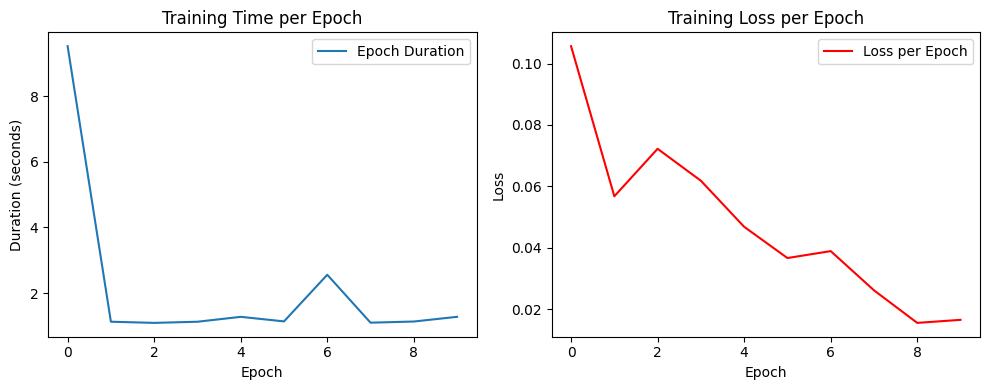

Test Accuracy: 0.9174


In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import matplotlib.pyplot as plt

# Load and preprocess data
def normalize(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

# Load the dataset along with its metadata
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))


# Apply normalization and batch data
train_dataset = train_dataset.map(normalize).cache().batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(normalize).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

model = CNN()
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 28, 28, 1)))['params']

optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, opt_state, batch):
    def loss_fn(params, x, y):
        logits = model.apply({'params': params}, x)
        loss = jnp.mean(optax.softmax_cross_entropy(logits, jax.nn.one_hot(y, 10)))
        return loss

    x, y = batch
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Prepare to collect metrics
epoch_durations = []
epoch_losses = []

for epoch in range(10):
    start_time = time.time()
    for batch in tfds.as_numpy(train_dataset):
        params, opt_state, loss = train_step(params, opt_state, batch)
    epoch_duration = time.time() - start_time
    epoch_durations.append(epoch_duration)
    epoch_losses.append(loss)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}, Time taken: {epoch_duration:.2f} seconds')

# Plot training time per epoch
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch_durations, label='Epoch Duration')
plt.xlabel('Epoch')
plt.ylabel('Duration (seconds)')
plt.title('Training Time per Epoch')
plt.legend()

# Plot loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epoch_losses, label='Loss per Epoch', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
test_accuracy = 0
for batch in tfds.as_numpy(test_dataset):
    x, y = batch
    logits = model.apply({'params': params}, x)
    predictions = jnp.argmax(logits, axis=1)
    test_accuracy += jnp.mean(predictions == y)
test_accuracy /= len(list(test_dataset))
print(f'Test Accuracy: {test_accuracy:.4f}')


Number of training examples: 60000
Number of test examples:     10000
Epoch 1/10
1875/1875 [==============================] - 18s 4ms/step - loss: 0.3971 - accuracy: 0.8577
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2564 - accuracy: 0.9064
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2099 - accuracy: 0.9239
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1831 - accuracy: 0.9327
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1539 - accuracy: 0.9432
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1337 - accuracy: 0.9502
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1101 - accuracy: 0.9594
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0947 - accuracy: 0.9658
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0800 - accuracy: 0.9707
Epoch 10/10

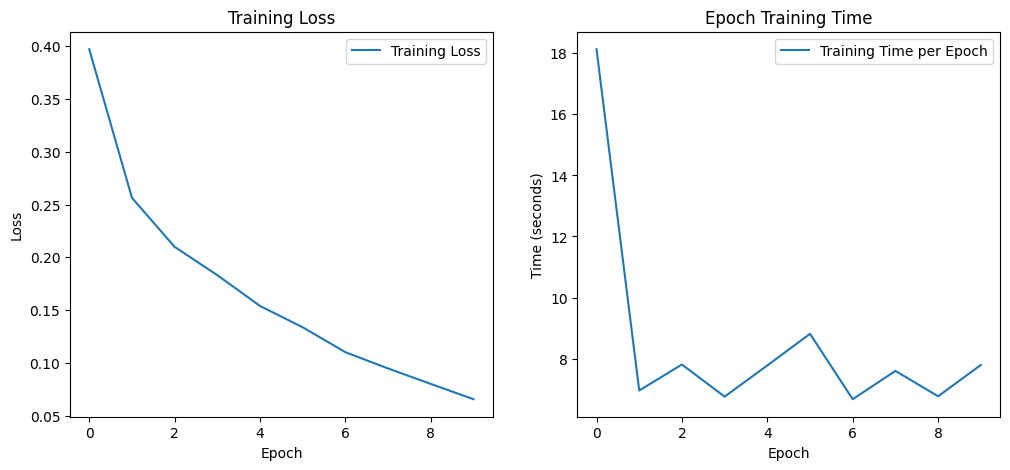

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import logging

# Disable TensorFlow's progress bar for a cleaner output
tfds.disable_progress_bar()

# Set the logger for TensorFlow
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

train_dataset = train_dataset.map(normalize).cache()
test_dataset = test_dataset.map(normalize).cache()

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Custom callback to record time taken for each epoch
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_start)

time_callback = TimeHistory()
history = model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE), callbacks=[time_callback])

test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_callback.times, label='Training Time per Epoch')
plt.title('Epoch Training Time')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()

plt.show()
